# Julia-Perple_X interface demo

This notebook runs the <a href="https://github.com/brenhinkeller/StatGeochem.jl" target="_blank">StatGeochem.jl</a> package, which implements an interface for interacting with <a href="https://www.perplex.ethz.ch" target="_blank">Perple_X</a> from the <a href="https://julialang.org" target="_blank">Julia programming language</a>, including from Jupyter notebooks such as this.

StatGeochem.jl also includes some of the codes and utilities used in <a href="https://doi.org/10.1038/nature11024" target="_blank">Keller & Schoene 2012</a>, <a href="https://doi.org/10.1038/nature14584" target="_blank">Keller et al. 2015</a> and <a href="https://doi.org/10.1016/j.epsl.2017.10.031" target="_blank">Keller & Schoene 2018</a>.

<a href="https://mybinder.org/v2/gh/brenhinkeller/StatGeochem.jl/main?filepath=examples%2FPerplexExamples.ipynb" target="_blank"><img src="https://mybinder.org/badge_logo.svg" alt="Launch Binder notebook" align="left"></a> 
<p style="text-indent: 5px">If running this notebook as an online Binder notebook and the webpage times out, click the badge at left to relaunch (refreshing will not work). Note that any changes will be lost!</p>

Hint: `shift`-`enter` to run a single cell, or from the `Cell` menu select `Run All` to run the whole file. Any code from this notebook can be copied and pasted into the Julia REPL or a `.jl` script.
***
### Load required Julia packages

In [1]:
## --- Load the StatGeochem package
using StatGeochem
using Plots

### Try to download and install Perple_X

In [2]:
## --- Configure

# Absolute paths to perplex resources
perplexdir = joinpath(resourcepath,"perplex-stable")
scratchdir = "./scratch/" # Location of directory to store output files

# Attempt to install perplex, if not already extant
if !isfile(joinpath(perplexdir,"vertex"))
    # Make sure resourcepath exists
    run(`mkdir -p $resourcepath`)

    # Try to compile PerpleX from source; if that fails, try to download linux binaries
    try
        # Check if there is a fortran compiler
        run(`gfortran -v`)

        # Download Perplex v6.8.7 -- known to work with interface used here
        file = download("https://storage.googleapis.com/statgeochem/perplex-6.8.7-source.zip", joinpath(resourcepath,"perplex-stable.zip"))

        # # For a more updated perplex version, you might also try
        # file = download("https://petrol.natur.cuni.cz/~ondro/perplex-sources-stable.zip", joinpath(resourcepath,"perplex-stable.zip"))

        run(`unzip -u $file -d $resourcepath`) # Extract
        system("cd $perplexdir; make") # Compile
    catch
        @warn "Failed to compile from source, trying precompiled linux binaries instead"
        run(`mkdir -p $perplexdir`)
        file = download("https://petrol.natur.cuni.cz/~ondro/Perple_X_6.8.7_Linux_64_gfortran.tar.gz","perplex-6.8.7-linux.tar.gz")
        run(`tar -xzf $file -C $perplexdir`)
    end
end

### Configure Perple_X options

In [3]:
## --- # # # # # # # # # # # # # Initial composition # # # # # # # # # # # # # #

## McDonough Pyrolite
#elements =    [ "SIO2", "TIO2", "AL2O3",  "FEO",  "MNO",  "MGO",  "CAO", "NA2O",  "K2O",  "H2O",  "CO2",]
#composition = [45.1242, 0.2005, 4.4623, 8.0723, 0.1354, 37.9043, 3.5598, 0.3610, 0.0291, 0.1511, 0.0440,]

## Kelemen (2014) primitive continental basalt. H2O and CO2 are guesses
#elements =    [ "SIO2", "TIO2", "AL2O3",  "FEO",  "MNO",  "MGO",  "CAO", "NA2O",  "K2O",  "H2O",  "CO2",]
#composition = [50.0956, 0.9564, 15.3224, 8.5103, 0.1659, 9.2520, 9.6912, 2.5472, 0.8588, 2.0000, 0.6000,]

# Kelemen (2014) primitive continental basalt excluding Mn and Ti since most melt models can"t handle them..
elements =    [ "SIO2", "AL2O3",  "FEO",  "MGO",  "CAO", "NA2O",  "K2O",  "H2O",  "CO2",]
composition = [50.0956, 15.3224, 8.5103, 9.2520, 9.6912, 2.5472, 0.8588, 2.0000, 0.6000,]

## Average Archean basalt (EarthChem data)
#elements =    [ "SIO2", "TIO2", "AL2O3",   "FEO",  "MNO",   "MGO",  "CAO", "NA2O",  "K2O",  "H2O",  "CO2",]
#composition = [49.2054, 0.8401, 12.0551, 11.4018, 0.2198, 12.3997, 9.3113, 1.6549, 0.4630, 1.8935, 0.5555,]

9-element Vector{Float64}:
 50.0956
 15.3224
  8.5103
  9.252
  9.6912
  2.5472
  0.8588
  2.0
  0.6

In [4]:
## --- # # # # # # # # # # # Some solution model options # # # # # # # # # # # #

# Emphasis on phases from Green (2016) -- developed for metabasites, includes what is probably the best (and most expensive) amphibole model. Use with hp11ver.dat
G_solution_phases = "Augite(G)\nOpx(JH)\ncAmph(G)\noAmph(DP)\nO(JH)\nSp(JH)\nGrt(JH)\nfeldspar_B\nMica(W)\nBio(TCC)\nChl(W)\nCtd(W)\nCrd(W)\nSa(WP)\nSt(W)\nIlm(WPH)\nAtg(PN)\nT\nB\nF\nDo(HP)\nScap\nChum\nNeph(FB)\n"
G_excludes ="ged\nfanth\ngl\nilm\nilm_nol\n"

# Emphasis on phases from White (2014) -- developed for metapelites. Use with hp11ver.dat (though can apparenty run with hp02ver.dat without crashing)
W_solution_phases = "Omph(HP)\nOpx(W)\ncAmph(DP)\noAmph(DP)\nO(JH)\nSp(JH)\nGt(W)\nfeldspar_B\nMica(W)\nBi(W)\nChl(W)\nCtd(W)\nCrd(W)\nSa(WP)\nSt(W) \nIlm(WPH)\nAtg(PN)\nT\nB\nF\nDo(HP)\nScap\nChum\nPu(M)\n"
W_excludes = "andr\nts\nparg\ngl\nged\nfanth\n"

# Emphasis on phases from Jennings and Holland (2015) -- developed for mantle melting. Use with hp11ver.dat
JH_solution_phases = "Cpx(JH)\nOpx(JH)\ncAmph(DP)\noAmph(DP)\nO(JH)\nSp(JH)\nGrt(JH)\nfeldspar_B\nMica(W)\nBio(TCC)\nChl(W)\nCtd(W)\nCrd(W)\nSa(WP)\nSt(W)\nIlm(WPH)\nAtg(PN)\nT\nB\nF\nDo(HP)\nScap\nChum\nNeph(FB)\n"
JH_excludes = "ts\nparg\ngl\nged\nfanth\n"

# Emphasis on phases from Holland and Powell -- all phases can be used with hp02ver.dat.
HP_solution_phases = "Omph(HP)\nOpx(HP)\nGlTrTsPg\nAnth\nO(HP)\nSp(HP)\nGt(HP)\nfeldspar_B\nMica(CF)\nBio(TCC)\nChl(HP)\nCtd(HP)\nSapp(HP)\nSt(HP)\nIlHm(A)\nDo(HP)\nT\nB\nF\n"
HP_excludes = ""

""

### Run Perple_X

In [5]:
## --- # # # # # # # # # # # # # Isobaric example # # # # # # # # # # # # # # # #

    # Input parameters
    P = 10000 # Pressure, bar
    T_range = (500+273.15, 1500+273.15) # Temperature range, Kelvin
    melt_model = "melt(G)"

    # Configure (run build and vertex)
    @time perplex_configure_isobar(perplexdir, scratchdir, composition, elements,
        P, T_range, dataset="hp11ver.dat", npoints=100, excludes=G_excludes,
        solution_phases=melt_model*"\n"*G_solution_phases)

## --- Query all properties at a single temperature -- results returned as text

    T = 1450+273.15
    data_isobaric = perplex_query_1d(perplexdir, scratchdir, T) |> print

 33.392907 seconds (114.44 k allocations: 7.876 MiB, 0.10% compilation time)


LoadError: UndefVarError: `perplex_query_1d` not defined

In [6]:
## --- Query the full isobar -- results returned as dict

bulk = perplex_query_system(perplexdir, scratchdir)             # Get system data for all temperatures. Set include_fluid = "n" to get solid+melt only
modes = perplex_query_modes(perplexdir, scratchdir)             # || phase modes
melt = perplex_query_phase(perplexdir, scratchdir, melt_model)  # || melt data

# Melt wt.% seems to be slightly inaccurate; use values from modes instead
melt["wt_pct"] = modes[melt_model]

# Create dictionary to hold solid composition and fill it using what we know from system and melt
solid = Dict()
solid["wt_pct"] = 100 .- melt["wt_pct"]
for e in ["SIO2","AL2O3","FEO","MGO","CAO","NA2O","K2O"]
    solid[e] = (bulk[e] - (melt[e] .* melt["wt_pct"]/100)) ./ (solid["wt_pct"]/100)
end
renormalize!(solid,["SIO2","AL2O3","FEO","MGO","CAO","NA2O","K2O"],total=100)

Dict{Any, Any} with 8 entries:
  "SIO2"   => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  52.0366, 52…
  "CAO"    => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  10.0663, 10…
  "K2O"    => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.891978, 0…
  "AL2O3"  => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  15.91, 15.9…
  "wt_pct" => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  1.7158, 1.7…
  "FEO"    => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  8.83931, 8.…
  "MGO"    => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  9.60967, 9.…
  "NA2O"   => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  2.64613, 2.…

#### Plot results

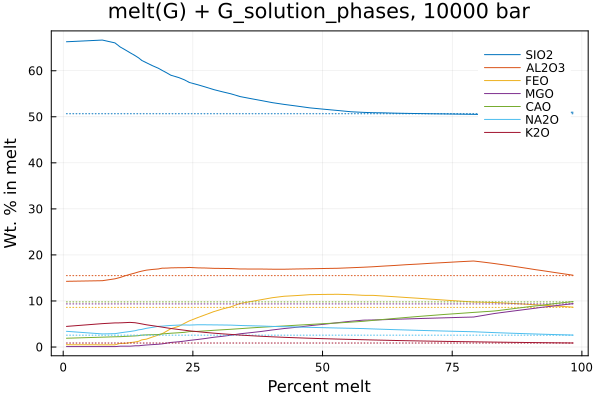

In [7]:
## --- Plot melt composition as a function of melt percent

h = plot(xlabel="Percent melt", ylabel="Wt. % in melt", title="$melt_model + G_solution_phases, $P bar")
i = 0
for e in ["SIO2","AL2O3","FEO","MGO","CAO","NA2O","K2O"]
    plot!(h, melt["wt_pct"], melt[e], label=e, color=lines[global i += 1])
    plot!(h, melt["wt_pct"], bulk[e], label="", color=lines[i], linestyle=:dot)
end
plot!(h,fg_color_legend=:white, framestyle=:box)
# savefig(h,"MeltComposition.pdf")
display(h)

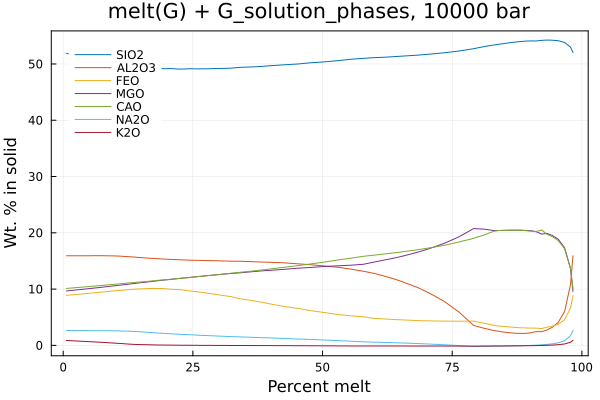

In [8]:
## --- Plot solid composition as a function of melt percent

h = plot(xlabel="Percent melt", ylabel="Wt. % in solid", title="$melt_model + G_solution_phases, $P bar")
i = 0
for e in ["SIO2","AL2O3","FEO","MGO","CAO","NA2O","K2O"]
    plot!(h, melt["wt_pct"], solid[e], label=e, color=lines[global i +=1])
end
plot!(h,fg_color_legend=:white, framestyle=:box, legend=:topleft)
# savefig(h,"SolidComposition.pdf")
display(h)

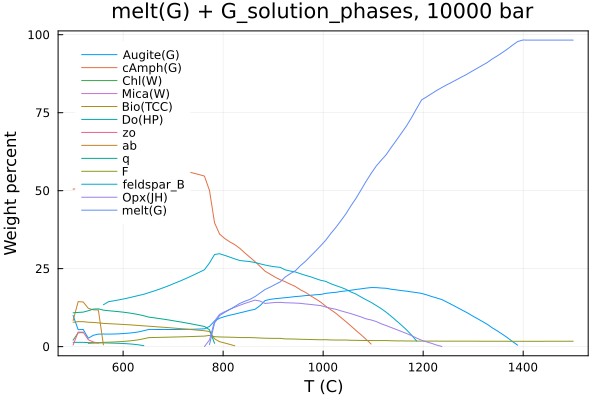

In [9]:
## --- Plot modes of all phases as a function of temperature

h = plot(xlabel="T (C)", ylabel="Weight percent", title="$melt_model + G_solution_phases, $P bar")
for m in modes["elements"][3:end]
    plot!(h, modes["T(K)"] .- 273.15, modes[m], label=m)
end
plot!(h,fg_color_legend=:white, framestyle=:box)
# savefig(h,"PhaseModes.pdf")
display(h)

In [10]:
## --- # # # # # # # # # # # Geothermal gradient example # # # # # # # # # # # #

# Input parameters
P_range = (280, 28000) # Pressure range to explore, bar (roughly 1-100 km depth)
T_surf = 273.15 # Temperature of surface (K)
geotherm = 0.1 # Geothermal gradient of 0.1 K/bar == about 28.4 K/km
melt_model = ""

# Configure (run build and vertex)
@time perplex_configure_geotherm(perplexdir, scratchdir, composition, elements,
    P_range, T_surf, geotherm, dataset="hp02ver.dat", excludes=HP_excludes,
    solution_phases=HP_solution_phases, npoints=200, index=2)

# # Alternative configuration, using hpha02ver.dat
# @time perplex_configure_geotherm(perplexdir, scratchdir, composition, elements,
#     P_range, T_surf, geotherm, dataset="hpha02ver.dat", excludes="qGL\n"*HP_excludes,
#     solution_phases=HP_solution_phases, npoints=200, index=2)

# # Alternative configuration, using hpha02ver.dat and new phases for metapelites
# @time perplex_configure_geotherm(perplexdir, scratchdir, composition, elements,
#     P_range, T_surf, geotherm, dataset="hpha02ver.dat", excludes="qGL\n"*W_excludes,
#     solution_phases=W_solution_phases, npoints=200, index=2)

Built problem definition
  1.197584 seconds (28.30 k allocations: 1.985 MiB, 2.02% compilation time)


0

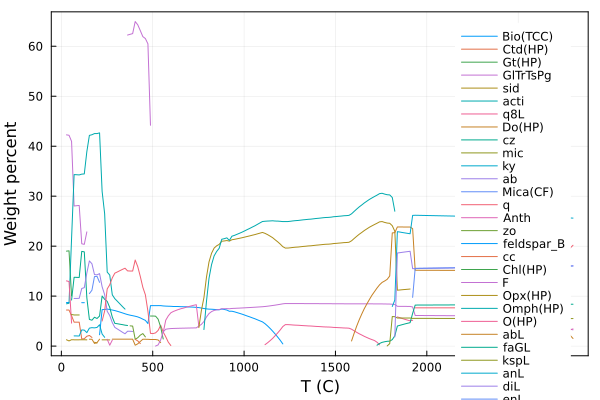

In [11]:
## --- Plot modes of all phases as a function of temperature

# Get phase modes
modes = perplex_query_modes(perplexdir, scratchdir, index=2)

h = plot(xlabel="T (C)", ylabel="Weight percent")
for m in modes["elements"][3:end]
    plot!(h, modes["T(K)"] .- 273.15, modes[m], label=m)
end
plot!(h,fg_color_legend=:white, framestyle=:box)
# savefig(h,"GeothermPhaseModes.pdf")
display(h)

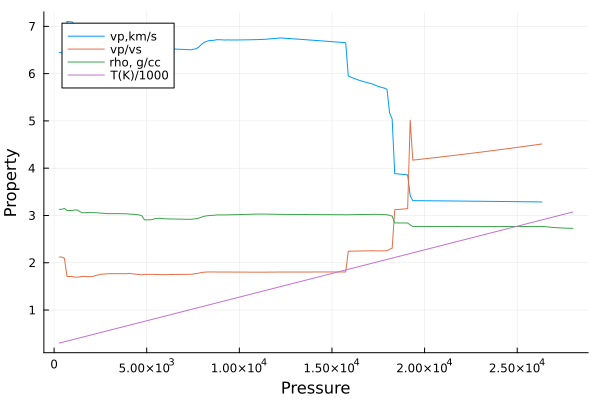

In [12]:
## --- Plot seismic properties

# Query seismic properties along the whole profile
seismic = perplex_query_seismic(perplexdir, scratchdir, index=2)
seismic["vp/vs"][seismic["vp/vs"] .> 100] .= NaN # Exclude cases where vs drops to zero

h = plot(xlabel="Pressure", ylabel="Property")
plot!(h,seismic["P(bar)"],seismic["vp,km/s"], label="vp,km/s")
plot!(h,seismic["P(bar)"],seismic["vp/vs"], label="vp/vs")
plot!(h,seismic["P(bar)"],seismic["rho,kg/m3"]/1000, label="rho, g/cc")
plot!(h,seismic["P(bar)"],seismic["T(K)"]/1000, label="T(K)/1000")
# savefig(h,"GeothermSeismicProperties.pdf")
display(h)